---

<div align=center>

# **Initialisation**

</div>

### Environment

In [1]:
!nvidia-smi

Tue Mar 28 17:08:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     On   | 00000000:3B:00.0 Off |                    0 |
| N/A   34C    P0    54W / 250W |      0MiB / 22698MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!nvcc --version

/bin/bash: line 1: nvcc: command not found


In [3]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Dependencies

In [4]:
import numpy as np
import tensorflow as tf
from LRFutils import archive, progress
from multiprocess import Pool, cpu_count
import psutil
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy as copy
import pickle
from time import time

2023-03-28 17:08:50.472171: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 17:08:51.578810: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda/lib64
2023-03-28 17:08:51.578906: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda/lib64
2023-03-28 17:08:51.578915: W tensorflow/compiler/tf2tensorrt/ut

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Configuration

In [6]:
valid_frac = 0.2
test_frac  = 0.1
dataset_path = "data/dataset"
epochs = 1000
batch_size=100

### Global variables

In [7]:
archive_path = archive.new(verbose=True)

try:
    ncpu = cpu_count()
except:
    with open(os.getenv("OAR_NODEFILE"), 'r') as f:
        ncpu = len(f.readlines())

def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

Archive created at ./archives/2023-03-28_c509a8f/20


### Useful functions

In [8]:
def system_info():
    return f"CPU: {psutil.cpu_percent()}%"\
        + f", RAM: {psutil.virtual_memory().percent}%"\
        + f" ({psutil.virtual_memory().used/1024**3:.2f}GB"\
        + f"/ {psutil.virtual_memory().total/1024**3:.2f}GB)"

def nb_vec(x:dict) -> int:

    for key in x.keys():
        assert len(x[key]) == len(x[list(x.keys())[0]]), "All dictionary element must be the same length"

    return len(x[list(x.keys())[0]])

def get_sample(x):
    sample = {}
    for key, value in x.items():
        sample[key] = value[0]
    return sample

def shuffle(x, y):

    nb_vectors = nb_vec(x)
    assert nb_vec(y) == nb_vectors, "x and y must have the same number of vectors"

    idx = np.random.permutation(nb_vectors)

    x_copy = copy(x)
    for key in x.keys():
        x_copy[key] = x[key][idx]

    y_copy = copy(y)
    for key in y.keys():
        y_copy[key] = y[key][idx]

    return x_copy, y_copy

def pick_vec(x, y, idx):
    vec_x = {}
    for key, value in x.items():
        vec_x[key] = value[idx]
    
    vec_y = {}
    for key, value in y.items():
        vec_y[key] = value[idx]

    return vec_x, vec_y

---

<div align=center>

# **Load data**

</div>

### Read one file

In [9]:
def load_file(file):

    data = np.load(file)

    x = {
        # "Dust Obs. Wavelenght [um]": np.array([250.,]), # dust observation frequency [um}
        "Dust Map" : data["dust_image"].reshape(*data["dust_image"].shape, 1), # adding a channel dimension
        # "CO Velocity" : data["CO_v"],
        # "CO Cube" : data["CO_cube"].reshape(*data["CO_cube"].shape, 1), # adding a channel dimension
        # "N2H+ Velocity" : data["N2H_v"],
        # "N2H Cube" : data["N2H_cube"].reshape(*data["N2H_cube"].shape, 1), # adding a channel dimension
    }
    
    y = {
        "Mass" : np.array(data["mass"]),
        # "Max Temperature" : np.array(np.amax(data["dust_temperature"])),
    }

    return x, y

### Load data

In [10]:
def load_data() -> tuple[np.ndarray, tuple[np.ndarray, np.ndarray, np.ndarray]]:
    """Do what you want int this function, as long as it returns the following:
    - list[3D-ndarray] : input vectors
    - list[3D-ndarray] : output vectors
    """

    # Limit of the number of vectors to load
    max_files = 1000
    files = os.listdir(dataset_path)
    nb_vectors = min(len(files), max_files)

    # Load data
    x = {}
    y = {}
    bar = progress.Bar(nb_vectors, "Loading data")
    for i, file in enumerate(files):
        if i >= nb_vectors:
            break
        bar(i, prefix=system_info())
        
        new_x, new_y = load_file(f"{dataset_path}/{file}")

        for key, value in new_x.items():
            if key not in x:
                x[key] = []
            x[key].append(value)

        for key, value in new_y.items():
            if key not in y:
                y[key] = []
            y[key].append(value)

    
    for key in x.keys():
        x[key] = np.array(x[key])
    
    for key in y.keys():
        y[key] = np.array(y[key])
        
    bar(nb_vectors)    
    return x, y

In [11]:
x, y = load_data()
nb_vectors = nb_vec(x)
x_labels = list(x.keys())
y_labels = list(y.keys())
x_shapes = [i[0].shape for i in x.values()]
y_shapes = [i[0].shape for i in y.values()]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 1000/1000 0:00:011 eta 0:00:00m


In [12]:
print(f"Number of vectors: {nb_vectors}")
print(f"X shapes:\n - ", '\n - '.join([f"{i}: {j}" for i, j in zip(x_labels, x_shapes)]))
print(f"Y shapes:\n - ", '\n - '.join([f"{i}: {j}" for i, j in zip(y_labels, y_shapes)]))   

Number of vectors: 1000
X shapes:
 -  Dust Map: (64, 64, 1)
Y shapes:
 -  Mass: ()


### Plot 10 random input vector 

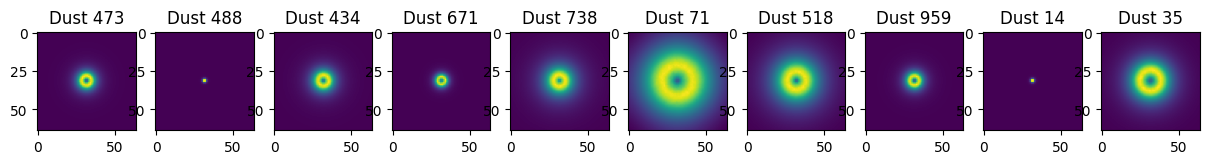

In [13]:
if is_notebook():

    nb_axs = 0
    if "Dust Map" in x: nb_axs += 1
    if "CO Cube" in x: nb_axs += 1
    if "N2H Cube" in x: nb_axs += 1

    fig, axs = plt.subplots(nb_axs, 10, figsize=(15, 5))
    if nb_axs == 1: axs = np.array([axs])

    for i in range(10):
        vec = np.random.randint(0, nb_vectors+1)
        nb_axis = 0
        if "Dust Map" in x:
            axs[nb_axis, i].imshow(x["Dust Map"][vec])
            axs[nb_axis, i].set_title(f"Dust {vec}")
            nb_axis += 1
        if "CO Cube" in x:
            axs[nb_axis, i].imshow(np.sum(x["CO Cube"][vec], axis=(-1,-2)))
            axs[nb_axis, i].set_title(f"CO {vec}")
            nb_axis += 1
        if "N2H Cube" in x:
            axs[nb_axis, i].imshow(np.sum(x["N2H Cube"][vec], axis=(-1,-2)))
            axs[nb_axis, i].set_title(f"N2H+ {vec}")
            nb_axis += 1

---

<div align=center>

# **Post processing**

</div>

### Normalisation

In [14]:
def normalize(x):

    x_maxs = {}
    for key, value in x.items():
        x_maxs[key] = np.max(value)
        x[key] /= x_maxs[key]

    return x_maxs

x_maxs = normalize(x)
y_maxs = normalize(y)

In [15]:
print("Maximum values:")
pd.DataFrame.from_records([x_maxs | y_maxs, ])

Maximum values:


,Dust Map,Mass
0,1154.924316,2.103129e+06


### Splitting datasets

In [16]:
def split(x, y, valid_frac=0.2, test_frac=0.1):

    nb_vectors = nb_vec(x)
    train_frac = 1 - valid_frac - test_frac
    
    train_x, valid_x, test_x = {}, {}, {}

    for key, value in x.items():
        train_x[key] = value[:int(nb_vectors*train_frac)]
        valid_x[key] = value[int(nb_vectors*train_frac):int(nb_vectors*(train_frac+valid_frac))]
        test_x[key] = value[int(nb_vectors*(train_frac+valid_frac)):]

    train_y, valid_y, test_y = {}, {}, {}

    for key, value in y.items():
        train_y[key] = value[:int(nb_vectors*train_frac)]
        valid_y[key] = value[int(nb_vectors*train_frac):int(nb_vectors*(train_frac+valid_frac))]
        test_y[key] = value[int(nb_vectors*(train_frac+valid_frac)):]

    return train_x, train_y, valid_x, valid_y, test_x, test_y

x, y = shuffle(x, y)

train_x, train_y, valid_x, valid_y, test_x, test_y = split(x, y, valid_frac, test_frac)

print(f"Train set: {nb_vec(train_x)} vectors")
print(f"Valid set: {nb_vec(valid_x)} vectors")
print(f"Test set: {nb_vec(test_x)} vectors")

Train set: 700 vectors
Valid set: 200 vectors
Test set: 100 vectors


---

<div align=center>

# **Model definition**

</div>

### Build model

In [17]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, MaxPooling3D, UpSampling2D, UpSampling3D, Reshape, Conv3DTranspose, Flatten
from keras.models import Model

def get_model(sample):

    inputs = {}
    for key, value in sample.items():
        inputs.update({key: Input(shape=value.shape, name=key)})

    # Encoder
    # x = Conv2D(8, (5, 5), activation='relu', padding='same')(input)
    # x = MaxPooling2D((4, 4), padding='same')(x)
    # x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    # x = MaxPooling2D((4, 4), padding='same')(x)
    # x = Flatten()(x)
    # x = Dense(1024, activation='relu')(x)

    x = Flatten()(inputs["Dust Map"])
    x = Dense(128, activation='relu')(x)
    total_mass = Dense(1, activation='relu')(x)

    # x = Flatten()(dust_map)
    # x = Dense(128, activation='relu')(x)
    # max_temperature = Dense(1, activation='relu')(x)

    outputs = {
        "Mass" : total_mass,
    }

    return Model(inputs, outputs)

### Compile model and get summary

In [18]:
model = get_model(get_sample(x))

def tf_pearson(y_true, y_pred):
    return tf.contrib.metrics.streaming_pearson_correlation(y_pred, y_true)[1]

loss = ['mean_squared_error']
optimizer = 'SGD'
metrics = ['mean_absolute_error']

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

# Store and print model summary
stringlist = []
model.summary(print_fn=lambda x: stringlist.append(x))
short_model_summary = "\n".join(stringlist)
print(short_model_summary)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dust Map (InputLayer)       [(None, 64, 64, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 128)               524416    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 524,545
Trainable params: 524,545
Non-trainable params: 0
_________________________________________________________________


### Training model

In [19]:
bar = progress.Bar(epochs)
bar(0)
stage=0

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        global bar
        bar(epoch, prefix = f"Loss: {logs['loss']:.2e}")

start_time = time()
history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_data=(valid_x, valid_y), verbose=0, callbacks=[CustomCallback()],
                    workers=1, use_multiprocessing=False)
training_time = time() - start_time
    
model.save(f'{archive_path}/model0.h5')
with open(f'{archive_path}/history', "wb") as file_pi:
    pickle.dump(history.history, file_pi)
bar(epochs)

score = model.evaluate(test_x, test_y, verbose=0)
print("Score:", score)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 1000/1000 0:01:10eta 0:00:00
Score: [0.0009380861883983016, 0.021442024037241936]


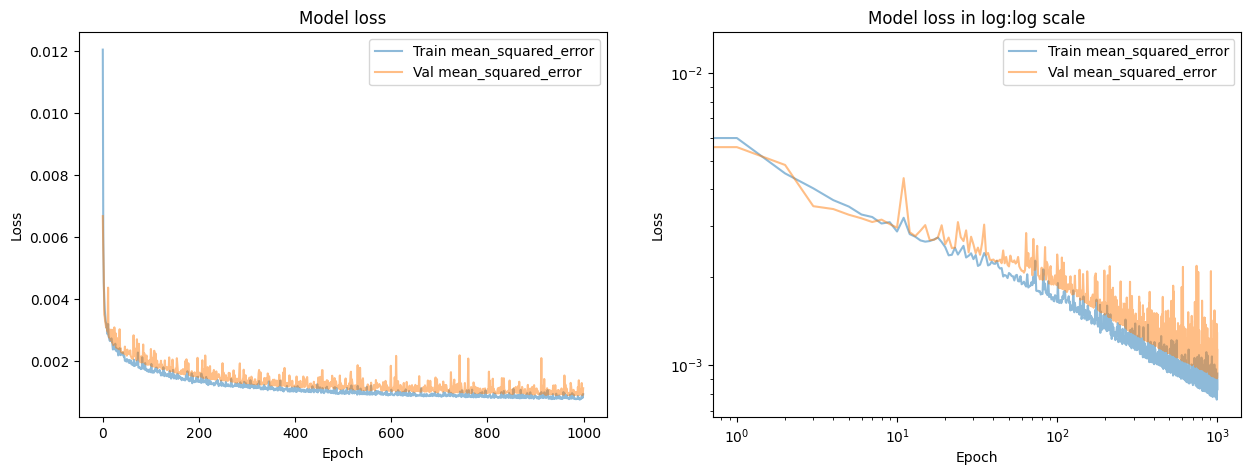

In [20]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
for l in loss:
    plt.plot(history.history['loss'], alpha=0.5, label=f'Train {l}')
    plt.plot(history.history['val_loss'], alpha=0.5, label=f'Val {l}')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
for l in loss:
    plt.plot(history.history['loss'], alpha=0.5, label=f'Train {l}')
    plt.plot(history.history['val_loss'], alpha=0.5, label=f'Val {l}')
plt.title('Model loss in log:log scale')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()

### Save model

In [21]:
with open(f"{archive_path}/model_summary.txt", "w") as text_file:
    text_file.write(short_model_summary + "\n")
    text_file.write(f"Loss: {loss}\n")
    text_file.write(f"Optimizer: {optimizer}\n")
    text_file.write(f"Metrics: {metrics}\n")
    text_file.write(f"Valid frac: {valid_frac}\n")
    text_file.write(f"Test frac: {test_frac}\n")
    text_file.write(f"Epochs: {epochs}\n")
    text_file.write(f"Batch size: {batch_size}\n")
    text_file.write(f"Training time: {training_time:.2f}s\n")
    text_file.write(f"Score: {score}\n")
    text_file.write(f"Path: {archive_path}")

np.savez_compressed(f'{archive_path}/results.npz', training_time=training_time, score=score)

In [22]:
inputs_txt = ','.join(x_labels).replace(' ', '_')
outputs_txt = ','.join(y_labels).replace(' ', '_')

file_path = f"data/model_comparison/{inputs_txt}---{outputs_txt}.txt"

with open(file_path, "a") as text_file:
        text_file.write(f"{archive_path}\n")

---

<div align=center>

# **Predictions**

</div>

In [23]:
r = np.random.randint(0, nb_vectors+1)
x_prediction, y_expected = pick_vec(x, y, r)
print(x_prediction.shape)

y_prediction = model.predict(x_prediction)[0,0]
print(y_prediction.shape)

print(f"Expected: {y_expected * y_maxs[0]:.2e} Msun")
print(f"Predicted: {y_prediction * y_maxs[0]:.2e} Msun")

np.savez_compressed(f'{archive_path}/prediction.npz', x=x_prediction, y=y_prediction, expected=y_expected)

AttributeError: 'dict' object has no attribute 'shape'